# Siphon (another Unidata product)

There is more than one way to remotely access data through Python scripts. We have previously used NetCDF4 to gain access to data from a remote webserver, however, we needed to know exact index values to subset the data. A newer tool, called Siphon and currently developed at Unidata (those same folks who brought us GEMPAK), will allow us to more easily access remote data through its querying methods.

https://unidata.github.io/siphon/latest/

We are going to use Siphon to access the most current GFS model output and from that data we will plot 850-hPa heights over the globe!

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.ndimage as ndimage
from datetime import datetime, timedelta, timezone
from netCDF4 import num2date
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

The key to Siphon is developing the query to get just the data that you need and accesses data on a THREDDS Data Server (TDS). A TDS is a web service to host data that has been developed at Unidata and there are many meteorological datasets hosted on THREDDS servers that you can access using Siphon. To learn more about THREDDS, please follow this link

http://www.unidata.ucar.edu/software/thredds/current/tds/catalog/

If you are looking for a dataset that you want to access using Siphon, you'll want to find the web address to the THREDDS catalogue that contains your dataset. Some example THREDDS sites are

http://thredds.ucar.edu/thredds/catalog.html <br>
http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis/catalog.html <br>
http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/NARR/catalog.html <br>
http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/20thC_ReanV2/catalog.html <br>
http://nomads.ncdc.noaa.gov/thredds/catalog/gfs-003-anl/catalog.html <br>
http://nomads.ncdc.noaa.gov/thredds/catalog/namanl/catalog.html <br>
http://nomads.ncdc.noaa.gov/thredds/catalog/ruc130anl/catalog.html

Notice that below, we will need to change the "html" to "xml" as the function TDSCatalog will parse the xml page.

In [2]:
# Latest GFS Dataset
cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p5deg_ana/latest.xml')
latest_ds = list(cat.datasets.values())[0]

So what is contained in this variable **latest_ds**?

In [3]:
for x in (latest_ds.access_urls):
    print(x,latest_ds.access_urls[x], sep=': ')

OPENDAP: http://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p5deg_ana/GFS_Global_0p5deg_ana_20171031_0600.grib2
HTTPServer: http://thredds.ucar.edu/thredds/fileServer/grib/NCEP/GFS/Global_0p5deg_ana/GFS_Global_0p5deg_ana_20171031_0600.grib2
WCS: http://thredds.ucar.edu/thredds/wcs/grib/NCEP/GFS/Global_0p5deg_ana/GFS_Global_0p5deg_ana_20171031_0600.grib2
WMS: http://thredds.ucar.edu/thredds/wms/grib/NCEP/GFS/Global_0p5deg_ana/GFS_Global_0p5deg_ana_20171031_0600.grib2
NetcdfSubset: http://thredds.ucar.edu/thredds/ncss/grib/NCEP/GFS/Global_0p5deg_ana/GFS_Global_0p5deg_ana_20171031_0600.grib2
CdmRemote: http://thredds.ucar.edu/thredds/cdmremote/grib/NCEP/GFS/Global_0p5deg_ana/GFS_Global_0p5deg_ana_20171031_0600.grib2
NCML: http://thredds.ucar.edu/thredds/ncml/grib/NCEP/GFS/Global_0p5deg_ana/GFS_Global_0p5deg_ana_20171031_0600.grib2
UDDC: http://thredds.ucar.edu/thredds/uddc/grib/NCEP/GFS/Global_0p5deg_ana/GFS_Global_0p5deg_ana_20171031_0600.grib2
ISO: http://thredds.ucar.edu/thred

These are the different web address (URLs) to obtain the data. For Siphon we are wanting to use the netCDFSubset service, so we'll want to use **'NetcdfSubset'** to access the data through our Siphon query.

To begin we need to call the appropriate Siphon function for the NetCDF Subset Service (NCSS) and feed it the appropriate web address. Then we'll need to build the query to go out and appropriately subset the data and bring it into the program.

But how do you determine what you can subset on? See the website...

http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p5deg/catalog.html

In [4]:
# Setting up the correct link to the data located somewhere on the WWW
print(latest_ds.access_urls['NetcdfSubset'])
ncss = NCSS(latest_ds.access_urls['NetcdfSubset'])

# We can subset on a number of different aspects 
# of the data: time, lat/lon, variable, etc.
# First initiate the query
query = ncss.query()

# Now let's build the query for Latest GFS Run, 
# we want all of the times from the
# latest GFS run and accept them in netCDF-4 convension
query.all_times().accept('netcdf4')

# Now lets subset and only bring in the Geopotential Height data
query.variables('Geopotential_height_isobaric',
                'Temperature_isobaric')

# Let's not bring in the whole globe, but just a subset over the U.S.
# Set the lat/lon box for the data you want to pull in.
# lonlat_box(north_lat,south_lat,east_lon,west_lon)
#query.add_lonlat().lonlat_box(-140,-50,10,70)
query.add_lonlat()

# Now specify the desired level 50000 = 50000 Pa = 500 hPa
query.vertical_level(85000)

print(query)
# Actually getting the data
data = ncss.get_data(query)

http://thredds.ucar.edu/thredds/ncss/grib/NCEP/GFS/Global_0p5deg_ana/GFS_Global_0p5deg_ana_20171031_0600.grib2
var=Geopotential_height_isobaric&var=Temperature_isobaric&temporal=all&accept=netcdf4&addLatLon=True&vertCoord=85000


So what did our query garner us?

In [5]:
print(list(data.variables),"\n")
print(data)

['Geopotential_height_isobaric', 'time', 'isobaric', 'lat', 'lon', 'Temperature_isobaric'] 

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Originating_or_generating_Center: US National Weather Service, National Centres for Environmental Prediction (NCEP)
    Originating_or_generating_Subcenter: 0
    GRIB_table_version: 2,1
    Type_of_generating_process: Analysis
    Analysis_or_forecast_generating_process_identifier_defined_by_originating_centre: Analysis from GFS (Global Forecast System)
    Conventions: CF-1.6
    history: Read using CDM IOSP GribCollection v3
    featureType: GRID
    History: Translated to CF-1.0 Conventions by Netcdf-Java CDM (CFGridWriter2)
Original Dataset = /data/ldm/pub/native/grid/NCEP/GFS/Global_0p5deg_ana/GFS_Global_0p5deg_ana_20171031_0600.grib2.ncx3#LatLon_361X720-p25S-180p0E; Translation Date = 2017-10-31T15:16:29.304Z
    geospatial_lat_min: -90.0
    geospatial_lat_max: 90.0
    geospatial_lon_min: 0.0
    

* How many variables do we have?
* What are the shapes of the variable arrays?

In our one query we are able to bring in all of the necessary data to be able to plot our desired quantity, the 500-hPa geopotential heights. But what does this look like?

Since we asked for the data in netCDF4 format, we can interact with it just like we would if we had a local netCDF file that we read in using the netCDF4 module.

To access our variables, we just need to make the proper object call, for example

data.variables['Geopotential_height_isobaric']

In [6]:
print("The shape of the Geopotential height array", 
      data.variables['Geopotential_height_isobaric'].shape,"\n")

# Get the name of the dimensions because grib is stupid
dtime = data.variables['Geopotential_height_isobaric'].dimensions[0]
dlev = data.variables['Geopotential_height_isobaric'].dimensions[1]

print("The time is in Forecast Hours")
print(data.variables[dtime].units)
print(data.variables[dtime][:],"\n")
print("We only have one level (since that is all we specified in our query)")
print(data.variables[dlev][:],"\n")
print("Latitudes ",data.variables['lat'][:],"\n")
print("Longitudes ",data.variables['lon'][:])

The shape of the Geopotential height array (1, 1, 361, 720) 

The time is in Forecast Hours
Hour since 2017-10-31T06:00:00Z
[ 0.] 

We only have one level (since that is all we specified in our query)
[ 85000.] 

Latitudes  [ 90.   89.5  89.   88.5  88.   87.5  87.   86.5  86.   85.5  85.   84.5
  84.   83.5  83.   82.5  82.   81.5  81.   80.5  80.   79.5  79.   78.5
  78.   77.5  77.   76.5  76.   75.5  75.   74.5  74.   73.5  73.   72.5
  72.   71.5  71.   70.5  70.   69.5  69.   68.5  68.   67.5  67.   66.5
  66.   65.5  65.   64.5  64.   63.5  63.   62.5  62.   61.5  61.   60.5
  60.   59.5  59.   58.5  58.   57.5  57.   56.5  56.   55.5  55.   54.5
  54.   53.5  53.   52.5  52.   51.5  51.   50.5  50.   49.5  49.   48.5
  48.   47.5  47.   46.5  46.   45.5  45.   44.5  44.   43.5  43.   42.5
  42.   41.5  41.   40.5  40.   39.5  39.   38.5  38.   37.5  37.   36.5
  36.   35.5  35.   34.5  34.   33.5  33.   32.5  32.   31.5  31.   30.5
  30.   29.5  29.   28.5  28.   27.5  27.   26

Let's now save this data to variable names that will be easier to work with...

In [7]:
hght_850 = data.variables['Geopotential_height_isobaric'][:].squeeze()
temp_850 = data.variables['Temperature_isobaric'][:].squeeze()

# Get the dimension data
lats = data.variables['lat'][:]
lons = data.variables['lon'][:]
levs = data.variables[dlev][:]
time = data.variables[dtime]
vtimes = num2date(time[:],time.units)

## Use Cartopy to Plot 850-hPa Heights

Same process as with other datasets, we just obtained our data through a different method.

In [8]:
# Make a grid of lat/lon values to use for plotting with Cartopy.
# The function meshgrid will create a two dimensional array from 
#     two 1D arrays for lats/lons
# Basically defining what the latitude and longitude value 
#     is at every grid point
clons, clats = np.meshgrid(lons, lats)
print(clons)
print(clons.shape)
print(clats)
print(clats.shape)

[[   0.     0.5    1.  ...,  358.5  359.   359.5]
 [   0.     0.5    1.  ...,  358.5  359.   359.5]
 [   0.     0.5    1.  ...,  358.5  359.   359.5]
 ..., 
 [   0.     0.5    1.  ...,  358.5  359.   359.5]
 [   0.     0.5    1.  ...,  358.5  359.   359.5]
 [   0.     0.5    1.  ...,  358.5  359.   359.5]]
(361, 720)
[[ 90.   90.   90.  ...,  90.   90.   90. ]
 [ 89.5  89.5  89.5 ...,  89.5  89.5  89.5]
 [ 89.   89.   89.  ...,  89.   89.   89. ]
 ..., 
 [-89.  -89.  -89.  ..., -89.  -89.  -89. ]
 [-89.5 -89.5 -89.5 ..., -89.5 -89.5 -89.5]
 [-90.  -90.  -90.  ..., -90.  -90.  -90. ]]
(361, 720)


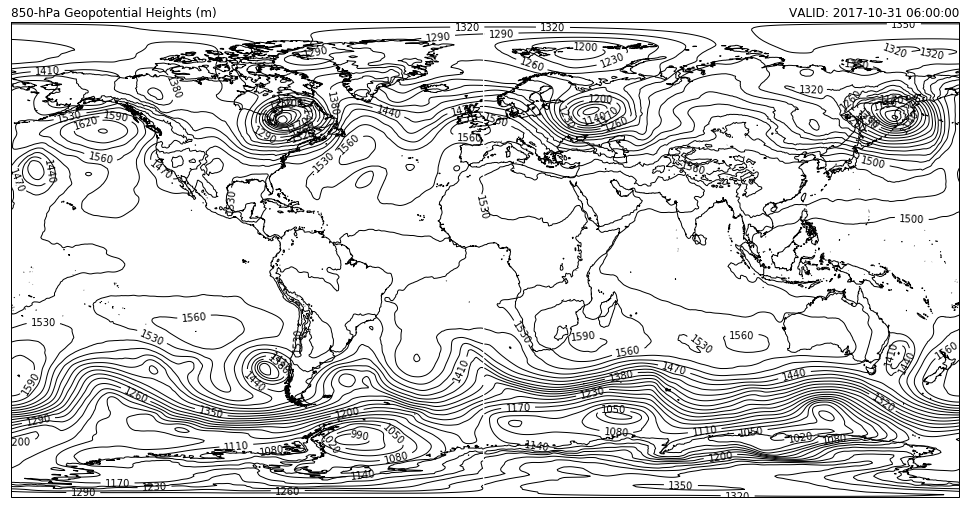

In [9]:
# Set map projection
mapcrs = ccrs.PlateCarree()

# Set up and plot figure
fig=plt.figure(1,figsize=(17.,11.))

# Set up the axes to plot on
ax = fig.add_subplot(111,projection=mapcrs)

# Set up the contour interval for temperature
# np.arange(min,max,interval)
cint = np.arange(0,4000,30)

# Do the contouring
# contour(x,y,variable,contour levels, line color, line width, line style)
cs = ax.contour(clons,clats,hght_850,cint,colors='k',
                linewidths=1.0,linestyles='solid')

# Label the contours
# clabel(contour handle, aspects of how the contour label will appear)
ax.clabel(cs, fontsize=10, inline=1, inline_spacing=5, fmt='%i',
          rightside_up=True, use_clabeltext=True)

# Plot the coastlines
ax.coastlines('50m',edgecolor='black',linewidth=0.75)

# Plot some titles
plt.title('850-hPa Geopotential Heights (m)',loc='left')
plt.title('VALID: %s' %(vtimes[0]),loc='right')

plt.show()

## Cyclic Points
Notice the very thin line that is missing from the image above, this is because we are trying to plot global data and we are missing the cyclic point that will allow us to connect the last data point to the first data point.

There is a function within Cartopy Utilities (util) that will allow us to easily add this point to a dataset.

In [10]:
import cartopy.util as cutil

# To add the cyclic point to one array
#lonsc = cutil.add_cyclic_point(lons)

# To add the cyclic point to the data array and the coordinate 
hght_850c, lonsc = cutil.add_cyclic_point(hght_850,coord=lons)

# Comparing the shape of the lons array from the lonsc (cyclic) array
print(lons[-2:])
print(lons.shape)
print(lonsc[-2:])
print(lonsc.shape)

[ 359.   359.5]
(720,)
[ 359.5  360. ]
(721,)


In [11]:
# Reset the grid with the cyclic data points
clons, clats = np.meshgrid(lonsc, lats)
print(clons.shape)
print(clats.shape)

(361, 721)
(361, 721)


### Map with Cyclic Data
Re-create the image from above, but now using the cyclic data so that we don't have a gap.

Beware of the clabel as it will produce some errors...use inline=False

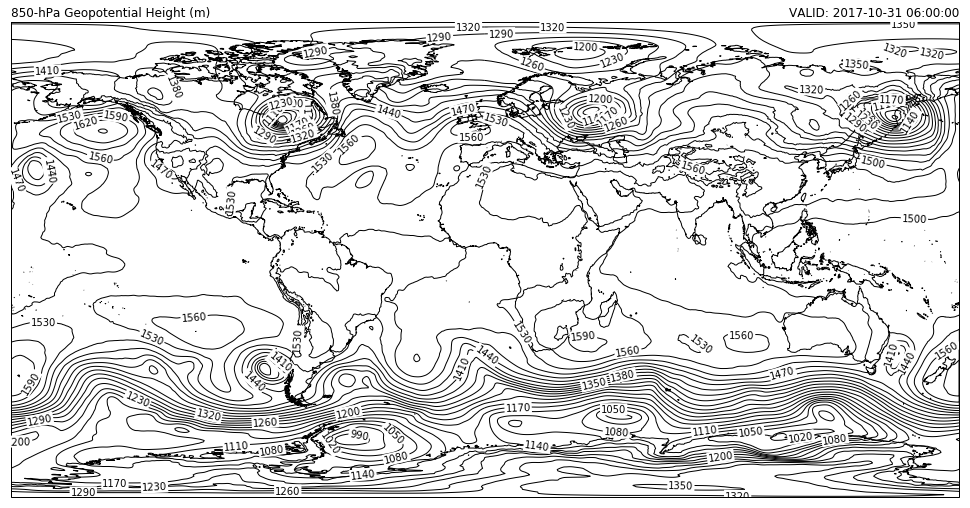

In [12]:
# Set map projection
mapcrs = ccrs.PlateCarree()

# Set up and plot figure
fig=plt.figure(1,figsize=(17.,11.))

# Set up the axes to plot on
ax = fig.add_subplot(111,projection=mapcrs)

# Set up the contour interval for temperature
# np.arange(min,max,interval)
cint = np.arange(0,4000,30)

# Do the contouring
# contour(x,y,variable,contour levels, line color, line width, line style)
cs = ax.contour(clons,clats,hght_850c,cint,colors='k',
                linewidths=1.0,linestyles='solid')

# Label the contours
# clabel(contour handle, aspects of how the contour label will appear)
t1 = ax.clabel(cs,inline=False,fmt='%d',use_clabeltext=True)
for t in t1:
    t.set_bbox(dict(fc='white',ec='none',pad=1))
               
# Plot the coastlines
ax.coastlines('50m',edgecolor='black',linewidth=0.75)

# Plot some titles
plt.title('850-hPa Geopotential Height (m)',loc='left')
plt.title('VALID: %s' %(vtimes[0]),loc='right')

plt.show()

## Colormaps
So far we have used the jet colormap, which is really not a very good colormap for a number of reasons. There are a number of different color maps that you could use, some of which are very useful for anomaly maps (diverging color maps). You can check out the different maps at http://matplotlib.org/examples/color/colormaps_reference.html

But how do we call these different maps?

In contourf or pcolormesh you can define a colormap with the keyword cmap. To access any of the color maps given at the reference above you would use the following

cmap = 'coolwarm'

cmap = 'hot'

or if you wanted one of the colormaps, but in reverse order you just add an underscore r (_r) to the name

cmap = 'gist_rainbow_r'

### Plotting Colorfill Map of 850-hPa Temperatures
Re-create the image from above, but now using the cyclic data 850-hPa temperatures.

In [13]:
temp_850c = cutil.add_cyclic_point(temp_850)
print(temp_850c)

[[ 255.0788269   255.0788269   255.0788269  ...,  255.0788269   255.0788269
   255.0788269 ]
 [ 255.37882996  255.37882996  255.37882996 ...,  255.37882996
   255.37882996  255.37882996]
 [ 255.67883301  255.67883301  255.67883301 ...,  255.5788269   255.67883301
   255.67883301]
 ..., 
 [ 239.97883606  239.97883606  239.97883606 ...,  239.97883606
   239.97883606  239.97883606]
 [ 239.97883606  239.97883606  239.97883606 ...,  239.97883606
   239.97883606  239.97883606]
 [ 240.17883301  240.17883301  240.17883301 ...,  240.17883301
   240.17883301  240.17883301]]


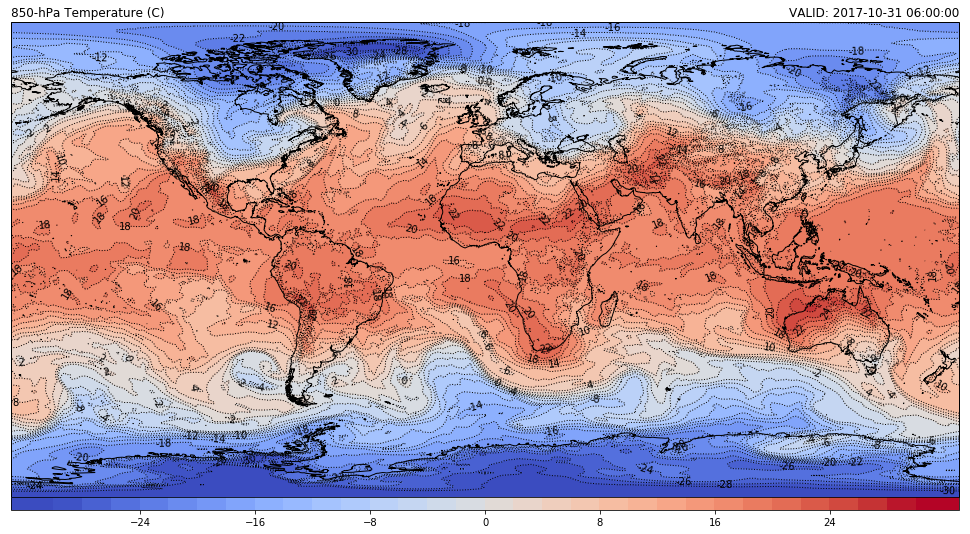

In [14]:
# Set map projection
mapcrs = ccrs.PlateCarree()

# Set up and plot figure
fig=plt.figure(2,figsize=(17.,12.))

# Set up the axes to plot on
ax = fig.add_subplot(111,projection=mapcrs)

# Set up map extent (whole globe in this case)
ax.set_extent([180,-180,-90,90],ccrs.Geodetic())

# Set up the contour interval for temperature
# np.arange(min,max,interval)
cint = np.arange(-30,31,2)

# Filled color contours
cf = ax.contourf(clons,clats,temp_850c-273.15,cint,cmap='coolwarm',extend='both')
# Set the colorbar to plot below the image
cbar = plt.colorbar(cf,orientation='horizontal',extend='both',
                    aspect=65,pad=0,extendrect='True')

# Regular contours
cs2 = ax.contour(clons,clats,temp_850c-273.15,cint,colors='k',
                 linewidths=1.0,linestyles='dotted')
# Set the contour labels
t1 = ax.clabel(cs2,inline=False,fmt='%d',use_clabeltext=True)
#for t in t1:
#    t.set_bbox(dict(fc='white',ec='none',pad=1))

# Plot some coastlines
ax.coastlines('50m',edgecolor='black',linewidth=0.75)

# Plot some titles
plt.title('850-hPa Temperature (C)',loc='left')
plt.title('VALID: %s' %(vtimes[0]),loc='right')

plt.show()

### In-class Problem #1
Re-create the image from above, but create a raster style image using pcolormesh.

Look up matplotlib pcolormesh to figure out how to create an image using that function instead of the contour or contourf functions.

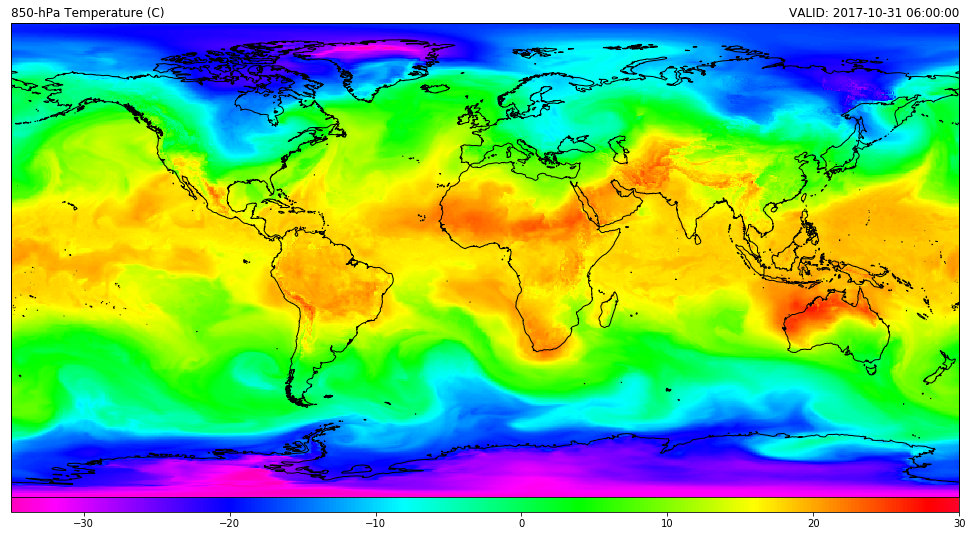

In [15]:
# Set map projection
mapcrs = ccrs.PlateCarree()

# Set up and plot figure
fig=plt.figure(2,figsize=(17.,12.))

# Set up the axes to plot on
ax = fig.add_subplot(111,projection=mapcrs)

# Set up map extent (whole globe in this case)
ax.set_extent([180,-180,-90,90],ccrs.Geodetic())


# Filled raster image with pcolormesh
cf = ax.pcolormesh(clons,clats,temp_850-273.15,vmin=-35,vmax=30,cmap='gist_rainbow_r')
# Set the colorbar to plot below the image
cbar = plt.colorbar(cf,orientation='horizontal',aspect=65,pad=0,extendrect='True')

# Plot some coastlines
ax.coastlines('50m',edgecolor='black',linewidth=0.75)

# Plot some titles
plt.title('850-hPa Temperature (C)',loc='left')
plt.title('VALID: %s' %(vtimes[0]),loc='right')

plt.show()